In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
%pylab inline

import json
import os

import devlib
from env import TestEnv
from wlgen import RTA
from perf_analysis import PerfAnalysis

import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    "platform"    : 'linux',
    "board"       : 'juno',
    "modules"     : ['bl', 'cpufreq'],
    "host"        : '192.168.0.10',
    "username"    : 'root',
    "password"    : '',
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }
}

# Setup the required Test Environment supports
my_tests_conf = {
    "modules" : ['hwmon'],
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency"
         ],
         "buffsize" : 10240
    },
    # The kernel to use for the experiments
    "kernel"  : '../../images/kernel_stune_v5.1.bin'
}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

03:56:38  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
03:56:38  INFO    : %14s - Loading custom (inline) target configuration
03:56:38  INFO    :         Target - Connecing linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
03:56:38  DEBUG   : Logging in root@192.168.0.10
03:56:40  DEBUG   : echo $PATH
03:56:40  DEBUG   : ls -1 /usr/local/bin
03:56:40  DEBUG   : cat /proc/cpuinfo
03:56:41  DEBUG   : id
03:56:41  DEBUG   : sudo -- sh -c 'dmidecode -s system-version'
03:56:42  DEBUG   : uname -m
03:56:42  DEBUG   : if [ -e '/sys/devices/system/cpu/cpufreq' ]; then echo 1; else echo 0; fi
03:56:43  DEBUG   : if [ -e '/sys/devices/system/cpu/cpu0/cpufreq' ]; then echo 1; else echo 0; fi
03:56:43  DEBUG   : if [ -e '/sys/class/hwmon' ]; then echo 1; else echo 0; fi
03:56:43  DEBUG   : ls -1 /sys/class/hwmon
03:56:44  DEBUG   : if [ -e '/sys/class/hwmon/hwmon0/name' ]; then echo 1; else echo 0; fi
03:56:44  DEBUG   : sudo -- sh -c 'c

# Workload configuration

In [5]:
rtapp = RTA(target, 'simple', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task_p20': RTA.periodic(
            period_ms=100,
            duty_cycle_pct=20,
            duration_s=5,
            # Run this task on the first CPU of the target
            cpus='0'),
        'task_r20_5-60': RTA.ramp(
            start_pct=5,
            end_pct=65,
            delta_pct=20,
            # Run this task on the last CPU of the target
            cpus=str(len(target.core_names)-1)),
    },
    run_dir=target.working_directory
);

03:57:21  ERROR   : Assuming taskset is preinstalled
03:57:21  INFO    : Setup new workload simple
03:57:21  INFO    : Workload duration defined by longest task
03:57:21  INFO    : Default policy: SCHED_OTHER
03:57:21  INFO    : ------------------------
03:57:21  INFO    : task [task_p20], sched: using default policy
03:57:21  INFO    :  | loops count: 1
03:57:21  INFO    :  | CPUs affinity: 0
03:57:21  INFO    :  + phase_000001: duration 5.000000 [s] (50 loops)
03:57:21  INFO    :  |  period   100000 [us], duty_cycle  20 %
03:57:21  INFO    :  |  run_time  20000 [us], sleep_time  80000 [us]
03:57:21  INFO    : ------------------------
03:57:21  INFO    : task [task_r20_5-60], sched: using default policy
03:57:21  INFO    :  | loops count: 1
03:57:21  INFO    :  | CPUs affinity: 5
03:57:21  INFO    :  + phase_000001: duration 1.000000 [s] (10 loops)
03:57:21  INFO    :  |  period   100000 [us], duty_cycle   5 %
03:57:21  INFO    :  |  run_time   5000 [us], sleep_time  95000 [us]
03:57:

# Workload execution

In [6]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir)

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
te.platform_dump(te.res_dir)

03:57:21  INFO    : #### Setup FTrace
03:57:21  DEBUG   : sudo -- sh -c 'echo 10240 > '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
03:57:22  DEBUG   : sudo -- sh -c 'cat '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
03:57:22  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd reset'
03:57:25  DEBUG   : sudo -- sh -c 'echo TRACE_MARKER_START > '\''/sys/kernel/debug/tracing/trace_marker'\'''
03:57:25  DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd start -e sched_switch -e cpu_frequency'
03:57:27  INFO    : #### Start energy sampling
03:57:28  DEBUG   : sudo -- sh -c 'cat '\''/sys/class/hwmon/hwmon13/energy1_input'\'''
03:57:28  DEBUG   : sudo -- sh -c 'cat '\''/sys/class/hwmon/hwmon14/energy1_input'\'''
03:57:28  INFO    : #### Start RTApp execution
03:57:28  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/simple_00.json
03:57:28  DEBUG   : /root/devlib-target/bin/rt-app /root/devlib-target/simple_00.json
03:57:34  DEBUG   : /us

In [7]:
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

03:57:39  INFO    : Content of the output folder /home/derkling/Code/schedtest/results/20151113_155721


total 3300
drwxrwxr-x  2 derkling derkling    4096 Nov 13 15:57 .
drwxrwxr-x 35 derkling derkling    4096 Nov 13 15:57 ..
-rw-rw-r--  1 derkling derkling      52 Nov 13 15:57 energy.json
-rw-rw-r--  1 derkling derkling     436 Nov 13 15:57 output.log
-rw-rw-r--  1 derkling derkling     649 Nov 13 15:57 platform.json
-rw-r--r--  1 derkling derkling    6360 Nov 13 15:57 rt-app-task_p20-0.log
-rw-r--r--  1 derkling derkling    5120 Nov 13 15:57 rt-app-task_r20_5-60-1.log
-rw-r--r--  1 derkling derkling    1828 Nov 13 15:57 simple_00.json
-rw-r--r--  1 derkling derkling 3338240 Nov 13 15:57 trace.dat


In [8]:
logging.info('Energy: %s', nrg_file)
logging.info('        %s', json.dumps(nrg))

03:57:39  INFO    : Energy: /home/derkling/Code/schedtest/results/20151113_155721/energy.json
03:57:39  INFO    :         {"big": "2.382257", "LITTLE": "9.813567"}


# Trace inspection

In [9]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# RTApp task performance plots

03:57:40  INFO    : Found rt-app logfile for task [task_r20_5-60]
03:57:40  INFO    : Found rt-app logfile for task [task_p20]
03:57:40  INFO    : Loading dataframe for task [task_p20]...
03:57:40  INFO    : Loading dataframe for task [task_r20_5-60]...
03:57:40  INFO    : PerfIndex, Task [task_p20] avg: 0.59, std: 0.01
03:57:40  INFO    : PerfIndex, Task [task_r20_5-60] avg: -4.17, std: 7.72


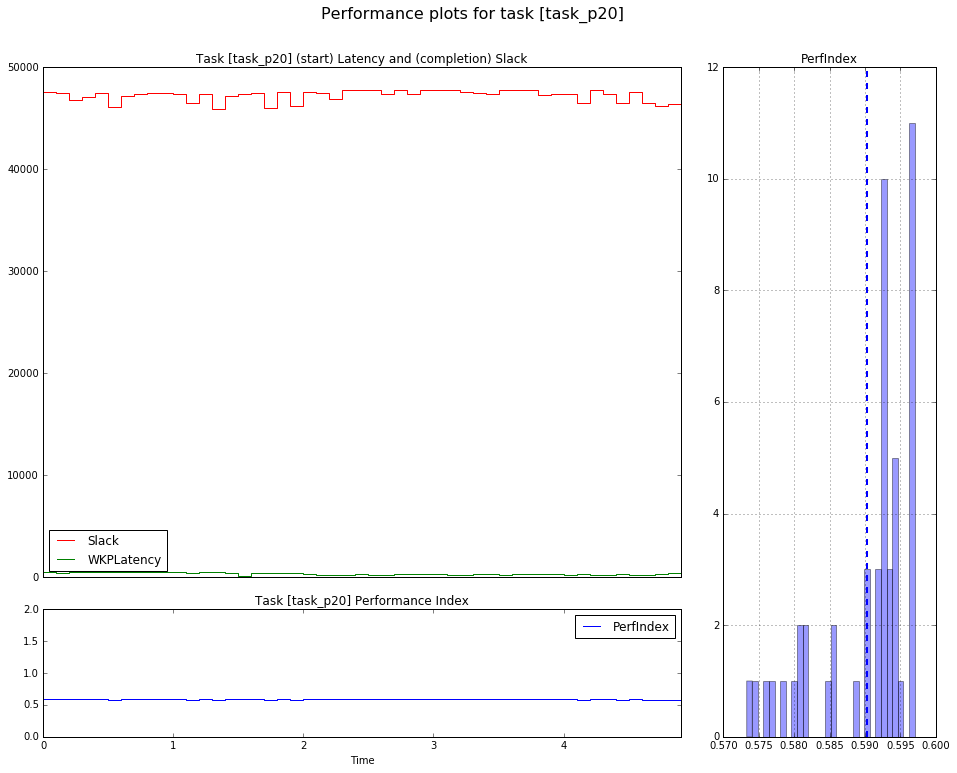

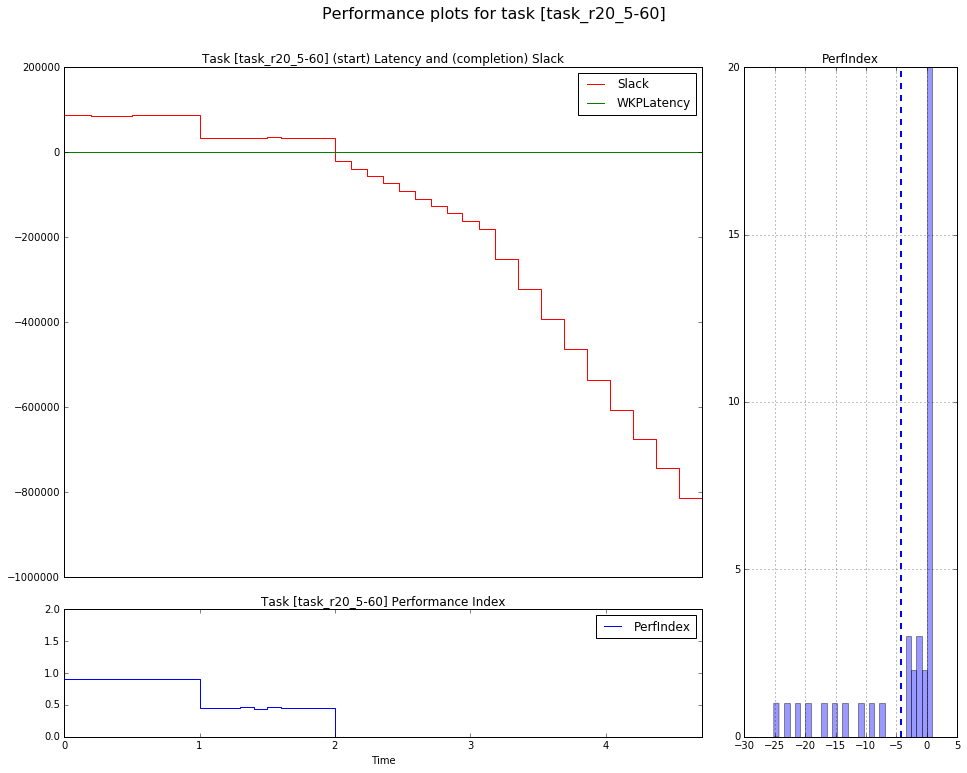

In [10]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))